# Display sequence of cutouts

Extract and display corresponding image cutouts from a sequence of files, previously determined by script *footprints.ipynb*. 

The distance from Earth's shadow cone at geosynchronous height is also computed and displayed.

Image files are retrieved from the APPLAUSE database via plate_id:

```
SELECT DISTINCT s.filename_scan
FROM applause_dr4.plate AS p
LEFT JOIN applause_dr4.scan AS s USING (plate_id)
WHERE s.filename_scan IS NOT NULL
AND p.plate_id = 19012
```

In [1]:
import warnings

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from astropy import units as u
from astropy.utils.exceptions import AstropyWarning

from erfa import ErfaWarning

from earthshadow import get_shadow_center, get_shadow_radius, dist_from_shadow_center

from library import plot_images
from settings import get_parameters, current_dataset, fname, sequences, images

In [2]:
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=ErfaWarning)
warnings.simplefilter('ignore', category=FutureWarning)

In [3]:
# define data set
par = get_parameters('9319,9320') # use display controls from here
seq = sequences['seq 03']

# source ID of object on plate 9319
source_id = 40349380007658

In [4]:
# extract 1-row table with object coordinates
table = Table.read(fname(par['table_non_matched']), format='fits')

mask = table['source_id'] == source_id
table_object = table[mask]

table_object

source_id,process_id_1,scan_id_1,plate_id_1,archive_id_1,solution_num,annular_bin_1,dist_center_1,dist_edge_1,sextractor_flags_1,model_prediction_1,ra_icrs,dec_icrs,ra_error,dec_error,gal_lon,gal_lat,ecl_lon,ecl_lat,x_sphere,y_sphere,z_sphere,healpix256,healpix1024,nn_dist,zenith_angle,airmass,natmag,natmag_error,bpmag,bpmag_error,rpmag,rpmag_error,natmag_plate,natmag_correction,natmag_residual,phot_range_flags,phot_calib_flags,color_term,cat_natmag,match_radius,gaiaedr3_id,gaiaedr3_gmag,gaiaedr3_bp_rp,gaiaedr3_dist,gaiaedr3_neighbors,timestamp_insert_1,timestamp_update_1,pos,process_id_2,scan_id_2,plate_id_2,archive_id_2,source_num,x_source,y_source,a_source,b_source,theta_source,erra_source,errb_source,errtheta_source,elongation,x_peak,y_peak,flag_usepsf,x_image,y_image,erra_image,errb_image,errtheta_image,x_psf,y_psf,erra_psf,errb_psf,errtheta_psf,mag_auto,magerr_auto,flux_auto,fluxerr_auto,mag_iso,magerr_iso,flux_iso,fluxerr_iso,flux_max,flux_radius,isoarea,sqrt_isoarea,background,sextractor_flags_2,dist_center_2,dist_edge_2,annular_bin_2,flag_rim,flag_negradius,flag_clean,model_prediction_2,timestamp_insert_2,timestamp_update_2
int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,bytes10,bytes10,bytes10,bytes10,bytes10,bytes10,float64,bytes15,bytes15,int64,int64,bytes9,bytes10,float64,bytes19,bytes4,bytes10,bytes12,int64,bytes29,bytes29,bytes42,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,bytes4,bytes4,bytes4,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bytes29,bytes29
40349380007658,34938,12209,9319,102,0,4,3248.3171,1061.8263,0,1.0,359.56717331456775,55.8796625754929,0.0968428,0.0834128,115.47776054780692,-6.220664977358579,30.123211279747515,49.57720175628767,0.5609168781911741,-0.004237387353368797,0.8278612808367626,226773,3628378,16.215902,17.767914,1.0499196,NULL,NULL,NULL,NULL,NULL,NULL,0.0,NULL,NULL,0,0,NULL,NULL,0.0,NULL,NULL,NULL,NULL,0,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.2756310564283 , 0.975284096845806)",34938,12209,9319,102,7658,5086.6753,1061.8238552112286,2.3742547,2.2668324,-49.867508,0.022372551,0.021500487,-72.44109,1.0473888,5087,1062,0,5086.6753,1061.8263,0.022372551,0.021500487,-72.44109,NULL,NULL,NULL,NULL,NULL,9.33182,0.011810238,1850428.6,20123.39,9.302416,0.007824958,1901226.4,13698.91,38214.902,2.9795022,89,9.433981,2401.1907,0,3248.3171,1061.8263,4,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00


In [5]:
# for Earth's shadow computation
longitude = 10.242    # TODO: take this from main csv input file instead
latitude  = 53.482

location = EarthLocation.from_geodetic(longitude, latitude, 0.0)
es_radius = get_shadow_radius(orbit='GEO', geocentric_angle=False)

In [6]:
# object's celestial coordinates
ra  = (table_object['ra_icrs'])
dec = (table_object['dec_icrs'])

target_coords = SkyCoord(ra=ra, dec=dec, unit='deg')

In [7]:
# full side of square cutout

size = 3./60. * u.deg    # arcmin

(198, 198)
9313   GS00762_x.fits
(197, 198)
9315   GS00764_x.fits
(197, 198)
9317   GS00766_x.fits
(197, 198)
9318   GS00767_x.fits
(197, 198)
9319   GS00768_x.fits
(197, 198)
9320   GS00769_x.fits
(198, 198)
9316   GS00765_x.fits


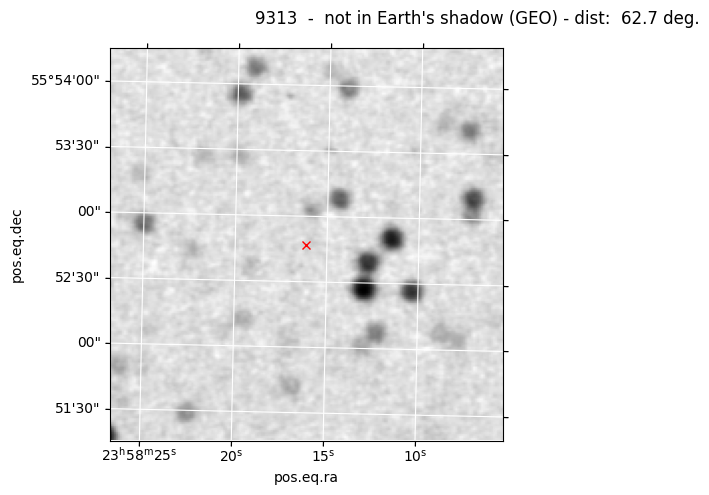

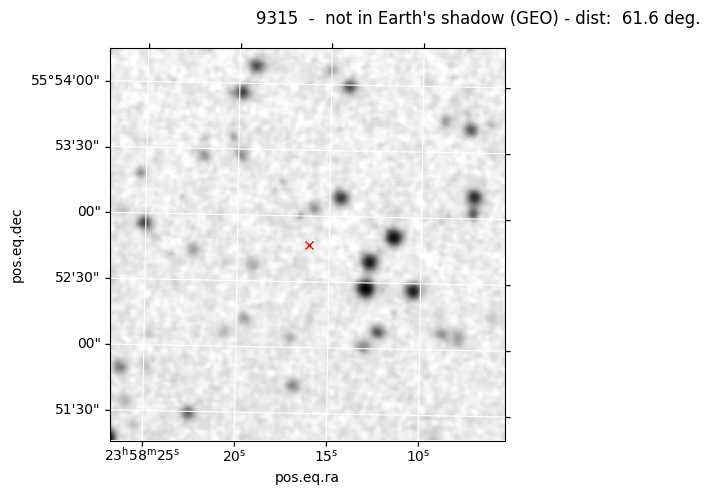

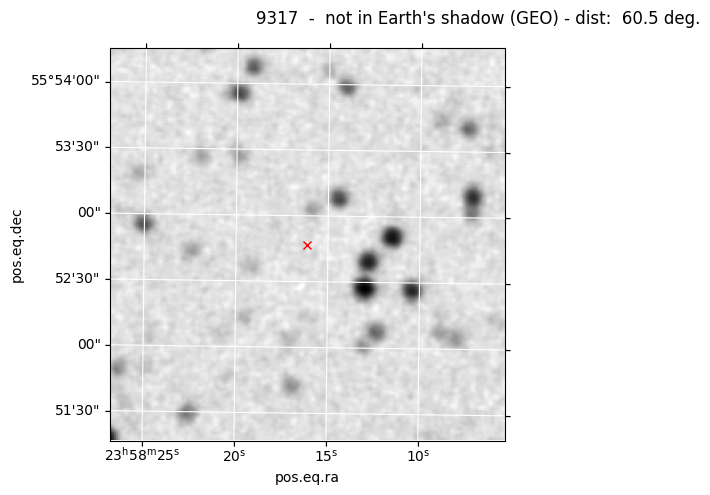

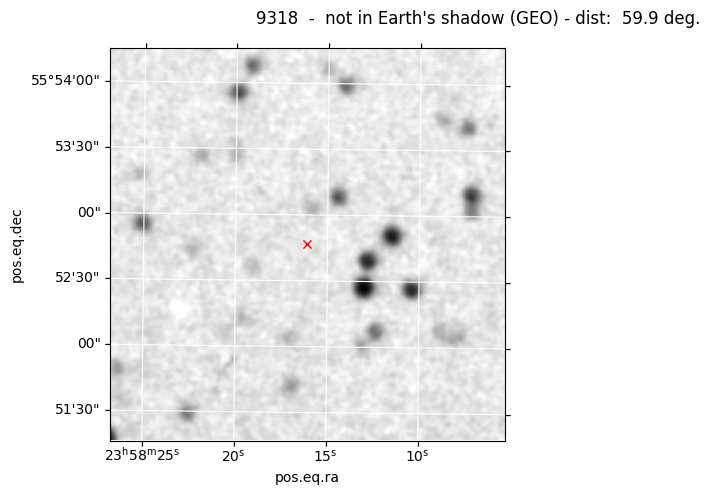

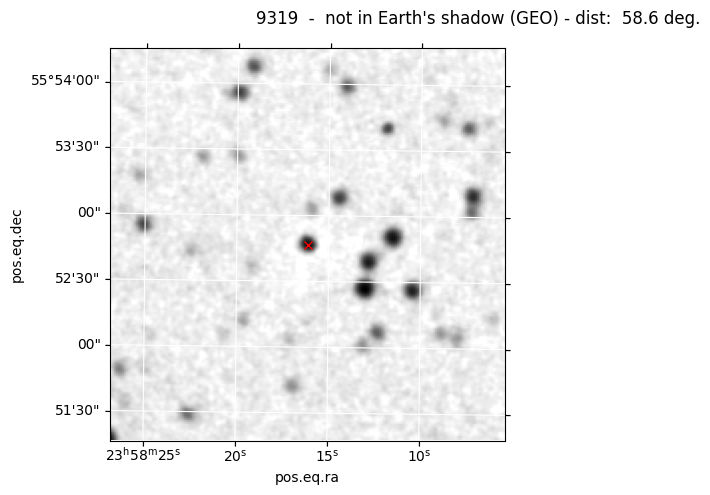

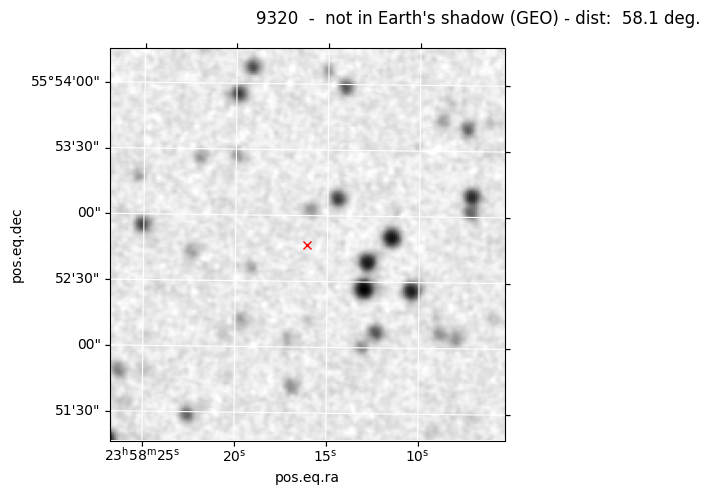

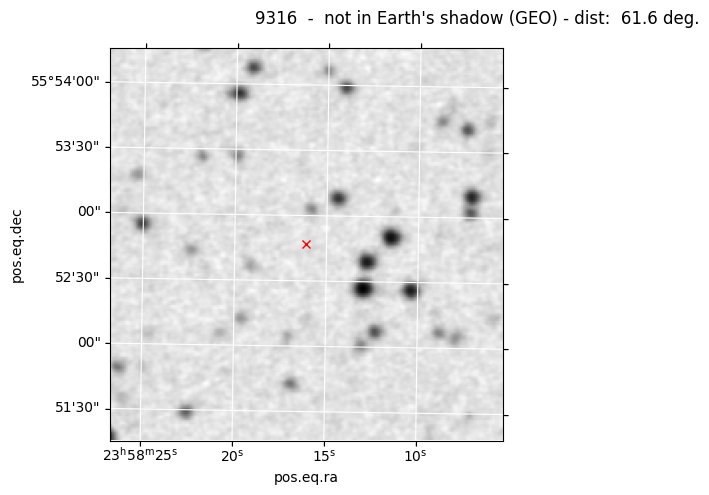

In [8]:
for plate_id in seq:
    try:
        image_name = images[str(plate_id)]
        
        # mid-exposure time from image header
        f = fits.open(fname(image_name))
        h = f[0].header
        time_stamp = h['DATE-AVG']
        time_event = Time(time_stamp)
        f.close()
        
        # Earth's shadow
        dist = dist_from_shadow_center(ra, dec, time=time_event, obs=location, orbit='GEO')
        for i, d in enumerate(dist):
            if d < es_radius - 2*u.deg:
                in_shadow = "in"
            else:
                in_shadow = "not"
    
        formatted_value = "{:.1f}".format(dist.to_value(u.deg)[0])
        title = str(plate_id) + "  -  " + in_shadow + " in Earth's shadow (GEO) - dist:  " + formatted_value + " deg."
    
        plot_images(fname(image_name), None, target_coords, size, title, 
                invert_east=par['invert_east'], invert_north=par['invert_north'])
        
        print(plate_id, ' ', image_name)

    except KeyError:

        print('no image file for ', plate_id)